In [11]:
# Lib imports
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np

In [31]:
train_dir = "C:/Users/User/Documents/Neural Network Assignment 6/train"
test_dir = "C:/Users/User/Documents/Neural Network Assignment 6/test"

In [32]:
# IMAGE PARAMETERS
# Used to resize the input images, also will determine the input size of your input layer.
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [33]:
# DATA PREPROCESSING & AUGMENTATION
# Optional but recommended for image processing tasks, especially with limited data.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 3788 images belonging to 2 classes.
Found 945 images belonging to 2 classes.
Found 945 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [34]:
#CNN MODEL ARCHITECTURE

# Some modifications are applied
initial_learning_rate = 0.001
# We are combining ExponentialDecay with Adam optimizer for better learning rate management
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Applied dropout layers to reduce overfitting and L2 regularization
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                  input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [35]:
# Configure the model optimizers, loss function, and metrics
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # old
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# TRAINING THE CNN
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - accuracy: 0.8828 - loss: 0.3409 - val_accuracy: 0.8847 - val_loss: 0.3079
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - accuracy: 0.8828 - loss: 0.3409 - val_accuracy: 0.8847 - val_loss: 0.3079
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 53s 440ms/step - accuracy: 0.8928 - loss: 0.3217 - val_accuracy: 0.9270 - val_loss: 0.2403
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 53s 440ms/step - accuracy: 0.8928 - loss: 0.3217 - val_accuracy: 0.9270 - val_loss: 0.2403
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 53s 441ms/step - accuracy: 0.8902 - loss: 0.3238 - val_accuracy: 0.9354 - val_loss: 0.2339
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 53s 441ms/step - accuracy: 0.8902 - loss: 0.3238 - val_accuracy: 0.9354 - val_loss: 0.2339
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 51s 427ms/step - accuracy: 0.8862 - loss: 0.3301 - val_accuracy: 0.9291 - val_loss: 0.2377
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 51s 427ms/step - accuracy: 0.8862 - loss: 0

In [41]:
# EVALUATE THE MODEL
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9189 - loss: 0.2573
Test Accuracy: 0.9189189076423645
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9189 - loss: 0.2573
Test Accuracy: 0.9189189076423645


In [ ]:
# SAVE THE MODEL
model.save('muffin_vs_chihuahua_cnn.h5')

In [26]:
# SIMPLE INFERENCE SCRIPT
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model_path='muffin_vs_chihuahua_cnn.h5'):
    model = tf.keras.models.load_model(model_path)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0,0]
    label = "Muffin" if pred >= 0.5 else "Chihuahua"
    print(f"Prediction: {label} (confidence: {pred:.2f})")


In [27]:
# IMAGE LOADING & DISPLAY WITH PREDICTION TITLE
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_show_and_predict(img_path):
    label, confidence = predict_image(img_path)

    img = image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {label} (confidence: {confidence:.2f})")
    plt.show()

    print(f"Prediction: {label} (confidence: {confidence:.2f})")



Image: C:/Users/User/Documents/chihuahua.jpg


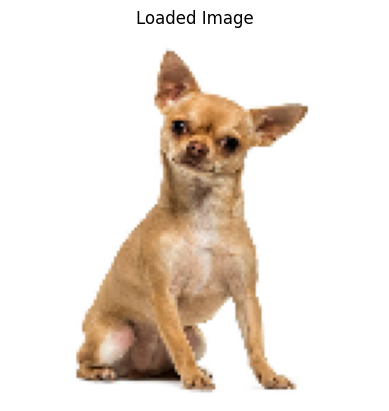

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Prediction: Chihuahua (confidence: 0.01)

Image: C:/Users/User/Documents/muffin.jpg


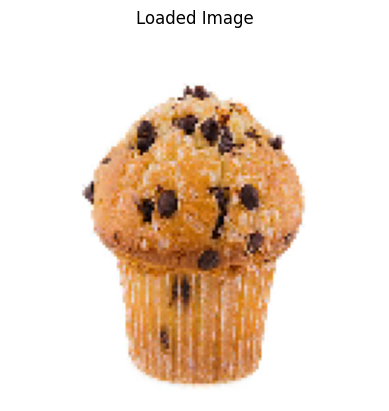

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Prediction: Muffin (confidence: 0.99)


In [30]:
# PREVIEW + PREDICT
test_images = [
    "C:/Users/User/Documents/chihuahua.jpg",
    "C:/Users/User/Documents/muffin.jpg",
]

for img_path in test_images:
    print(f"\nImage: {img_path}")
    load_and_show_image(img_path, IMG_SIZE)
    predict_image(img_path)
